# Pre-MySQL Cleaning Notebook
### Author: Emmanuel Paalam
### Date: 07/16/2025

This notebook was created to perform the necessary cleanings on the dimensionally dense dataset from the Educational Longitudinal Study of 2002 (ELS:2002) prior to MySQL table creation and insertion for a CAP4770 group project.

The decided use for the data by the group (author, Charles Smith, Everett Williams) was to examine the survey's recorded participant data from the baseline year of the study to its first follow up, thus lasting from 10th grade to 12th grade for participants. At this point, participants should be either graduating or have dropped out of school at some point: our goal is to assess the data collected in this two-year period and characterize dropouts and non-dropouts accordingly.

## Load in CSV data

Data downloadable from https://nces.ed.gov/datalab/onlinecodebook/session/codebook/d27ac790-3fdf-452d-ba74-e33e786024da.

This notebook assumes that it exists in a directory in which it shares a parent directory with the data, the latter located in a neighboring child folder called *data*. Pathways should be changed as needed for alternate project implementation - all that matters is that the appropiate file is used for cleaning.

In [1]:
import pandas as pd
df = pd.read_csv('data/els_02_12_byf3pststu_v1_0.csv')
df.shape

C:\Users\epaal\AppData\Local\Temp\ipykernel_8712\2311857552.py:2: DtypeWarning: Columns (1222) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/els_02_12_byf3pststu_v1_0.csv')


(16197, 4012)

In [2]:
df.head()

,STU_ID,SCH_ID,STRAT_ID,PSU,F1SCH_ID,F1UNIV1,F1UNIV2A,F1UNIV2B,F2UNIV1,F2UNIV_P,...,BYF10D,BYF10E,BYF10F,BYF10G,BYF10H,BYF10I,BYF10J,BYF10K,BYF10L,BYF10M
0,101101,-5,101,1,1011,101,1,1,-5,103,...,0,1,1,1,1,1,1,1,0,0
1,101102,-5,101,1,1011,101,1,1,-5,101,...,0,1,1,1,1,1,1,1,0,0
2,101104,-5,101,1,1011,101,1,1,-5,101,...,0,1,1,1,1,1,1,1,0,0
3,101105,-5,101,1,1011,101,1,1,-5,101,...,0,1,1,1,1,1,1,1,0,0
4,101106,-5,101,1,1011,101,1,1,-5,101,...,0,1,1,1,1,1,1,1,0,0


At this point, it should be clear why a pre-MySQL cleaning is needed: there are far too many columns (attributes) in the raw data, many of which are not needed by us.

## Column + Row Removal

As a note, there are actually a lot of missing values in the data - any non-responses per student will be recorded as a negative value (e.g.: -9 for "Not Applicable", -8 for "Refused to answer", -7 for "Item legitimate skip"), and there are many rows with these. However, we should decide what to do with these "missings" when needed - this can still be valuable information too. EDA, for example, may benefit from including these missings as part of the process of describing the dataset.

Meanwhile, irrelevant data (anything not from the baseline year or first follow-up) make up almost half of the dataset. Let's see how much of our dataset is truly needed with this in mind.

In [3]:
df = df.filter(regex='^(?!F2|F1T|F3)')
df.shape

(16197, 2727)

Still, a lot of the remaining variables include non-informative columns (e.g.: ID variables, estimated variables like BYTXMIRR or BYNELS2M, comparative variables like BYPISAME or BYPISARE).

The goal of this pre-table clean is to establish a solid collection of academic and non-academic attributes on all students, so I, the author, will now manually extract a number of columns that I deem useful for our project based on found literature.

In [4]:
df_selected = pd.DataFrame()

selected_columns = [
    # === Core Identifiers & Target Variable ===
    "STU_ID",          # Unique student identifier, essential for merging data
    "F1EVERDO",        # Target Variable: 1st follow-up, student ever dropped out (0=No, 1=Yes)

    # === Academic Background & Performance ===
    "BYTXRSTD",        # Standardized test score, reading (continuous)
    "BYTXMSTD",        # Standardized test score, math (continuous)
    "BYSCHPRG",        # Student's high school program (e.g., academic, general, vocational)
    "BYGRDRPT",        # Ever repeated a grade from 1st to 9th
    "BYS33A",          # Ever in an Advanced Placement (AP) program
    "BYS33D",          # Ever in a remedial English class
    "BYS33E",          # Ever in a remedial Math class
    "BYS33H",          # Ever in a dropout prevention program

    # === Student Behaviors & Engagement ===
    "BYHMWRK",         # Hours spent on homework per week, base year
    "BYXTRACU",        # Participation in extracurricular activities
    "BYS24A",          # How many times late for school, base year
    "BYS24B",          # How many times cut/skipped class, base year
    "BYS24C",          # How many times absent from school, base year
    "BYS38C",          # Goes to class without homework done, base year
    "F1S31",           # In-school student: hours/week on homework, 1st follow-up

    # === Psychosocial & Attitudinal Factors ===
    "BYSTEXP",         # Student's educational expectations, base year
    "F1STEXP",         # Student's educational expectations, 1st follow-up
    "BYSES1",          # Socioeconomic status (SES) composite 1, base year (continuous)
    "BYS89A",          # Self-concept: confident can do excellent on math tests
    "BYS89I",          # Self-concept: confident can do excellent on English assignments
    "BYS89E",          # Locus of control: 'When I learn something hard, I can learn it'
    "BYS89N",          # Locus of control: 'If I decide not to get bad grades, I can do it'
    "BYS20A",          # School climate: students get along with teachers
    "BYS20B",          # School climate: there is real school spirit
    "BYS20J",          # School climate: student doesn't feel safe at this school
    "BYS20K",          # School climate: disruptions get in way of learning

    # === Peer Group Influence ===
    "BYS90B",          # Peer group attitudes: importance of studying
    "BYS90D",          # Peer group attitudes: importance of getting good grades
    "BYS90F",          # Peer group attitudes: importance of finishing high school
    "BYS90L",          # Peer group attitudes: importance of getting together on weekends
    "BYS91",           # Number of close friends who dropped out

    # === Family, Home & Financial Factors ===
    "BYINCOME",        # Total family income for 2001
    "F1MOTHED",        # Mother's highest level of education, 1st follow-up
    "F1FATHED",        # Father's highest level of education, 1st follow-up
    "F1OCCUM",         # Mother's occupation, 1st follow-up
    "F1OCCUF",         # Father's occupation, 1st follow-up
    "BYFCOMP",         # Family composition, base year
    "F1FCOMP",         # Family composition, 1st follow-up
    "BYHOMLNG",        # Language spoken at home other than English
]

for col in selected_columns:
    df_selected[col] = df[col]

df_selected.shape

(16197, 41)

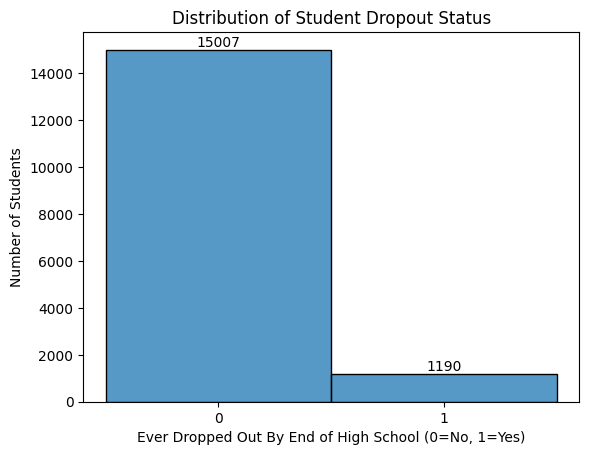

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

bars = sns.histplot(data=df_selected, x="F1EVERDO", discrete=True)
bars.set_xticks([0, 1])
plt.xlabel("Ever Dropped Out By End of High School (0=No, 1=Yes)")
plt.ylabel("Number of Students")
plt.title("Distribution of Student Dropout Status")

for container in bars.containers:
    bars.bar_label(container)

plt.show()

## Table Creation

This portion of the notebook assumes MySQL is installed and a local instance of the server is prepared, plus that all of the required dependencies in the following cell are available.

MySQL has an installer that can be downloaded here: https://dev.mysql.com/downloads/installer/. Once you have *Workbench* and *Server* installed locally, **enter your own admin password into *db_config*.** The input host value allows create_engine to loop back to your computer when searching for the MySQL server to connect to - and your computer will have a local MySQL instance at this point if *Server* was installed.

In [ ]:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine


# --- 1. Database Connection Details ---
db_config = {
    'user': 'root',
    'password': 'YOUR_ROOT_PASSWORD_HERE', # Replace with your password
    'host': '127.0.0.1',
    'raise_on_warnings': True
}

db_name = 'els2002_selected_columns' # The name of the database you want to use


# --- 2. Create the Database (if it doesn't exist) ---
try:
    # Connect to the MySQL server
    cnx = mysql.connector.connect(**db_config)
    cursor = cnx.cursor()
    
    # Create the database
    cursor.execute(f"CREATE DATABASE IF NOT EXISTS {db_name}")
    print(f"Database '{db_name}' is ready.")
    
    cursor.close()
    cnx.close()

except mysql.connector.Error as err:
    print(f"Failed to create database: {err}")


# --- 3. Load DataFrame into a SQL Table ---
try:
    # Create a SQLAlchemy engine to talk to the database
    engine = create_engine(f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_name}")
    
    table_name = 'els_2002_data' # Choose a name for your table
    
    # Use pandas to_sql to load the data
    # 'if_exists='replace'' will overwrite the table if it already exists.
    # Use 'append' if you want to add data, or 'fail' to prevent overwriting.
    df_selected.to_sql(table_name, engine, if_exists='replace', index=False)
    
    print(f"DataFrame successfully loaded into table '{table_name}'.")

except Exception as e:
    print(f"Failed to load data into MySQL: {e}")